# Extrapolation Example

This is an example of `SymplecticMapTools.jl`. The example exists both as a
webpage and as a notebook. To find the notebook, simply go to the `/examples/`
folder in the package directory.

We will show how sequence extrapolation can be used for finding invariant
circles of the Chirikov standard map. The standard map is given by
$$
\begin{aligned}
    x_{t+1} &= x_t + y_{t+1} \mod 1, \\
    y_{t+1} &= y_t - \frac{k}{2\pi} \sin(2\pi x_t).
\end{aligned}
$$

For this example, we will use $k=0.7$, which gives a nice mix of chaos,
invariant circles, and islands.

In [1]:
using Revise
using SymplecticMapTools
using CairoMakie
using LinearAlgebra

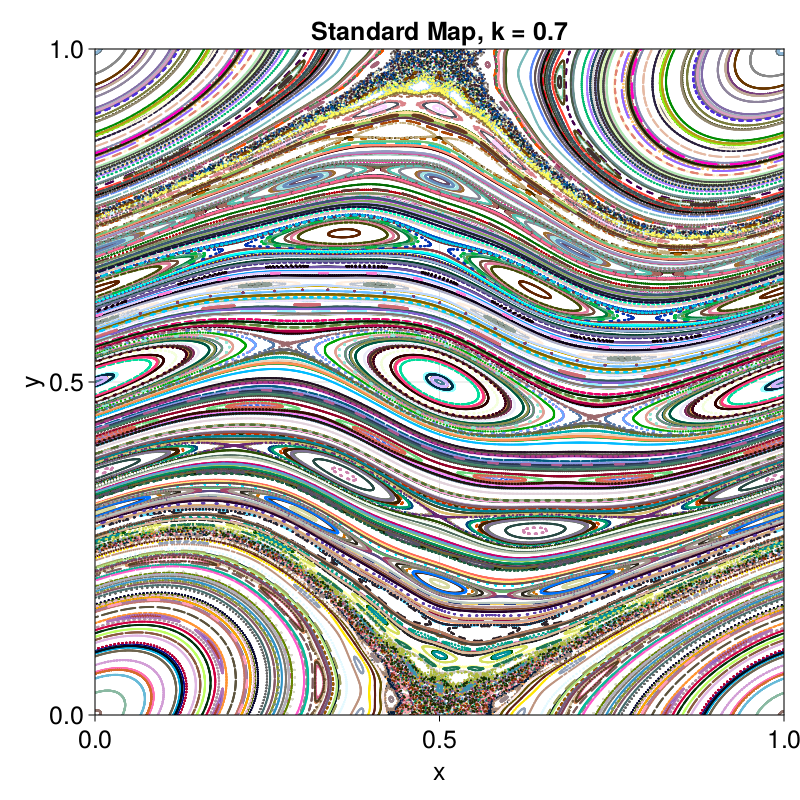

In [2]:
k_sm = 0.7
F = standard_map_F(k_sm)

f, xs_pp = poincare_plot([0,1], [0,1], F, 500, 1000, title="Standard Map, k = $(k_sm)")
f

The extrapolation method presented here has two steps:
1. Perform an extrapolation method (minimal polynomial extrapolation (MPE) or
   reduced rank extrapolation (RRE)). The extrapolation method returns a
   filter for the sequence. When the linear model is applied to the sequence,
   it can extract the mean (also known as the Birkhoff ergodic average).
   Additionally, if the extrapolation returns a low residual, this can be used
   as an indicator that the trajectory is integrable (i.e. it is an invariant
   circle or island) rather than chaotic.
2. If the trajectory is classified as integrable, we can extract frequency
   information from the learned filter. This can be used to recover the
   rotation number, as well as the Fourier modes of the invariant structures.

As first step, we choose some initial points. The above plot was made using
initial points sampled from a `SoboloSeq` (see
[Sobol.jl](https://github.com/JuliaMath/Sobol.jl)). So, we will simply use
those:

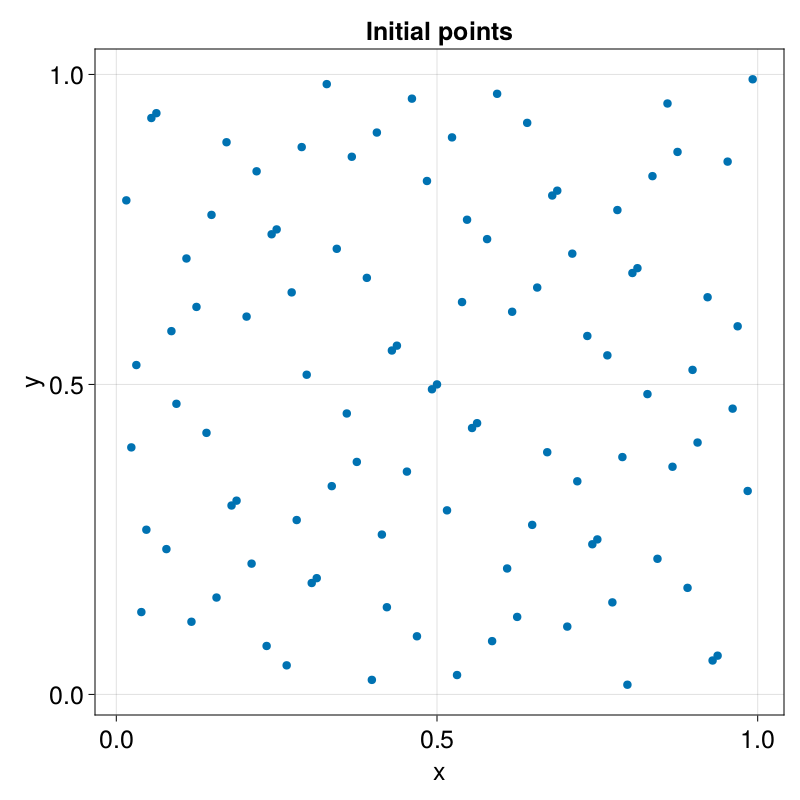

In [3]:
Ncircle = 100

resolution=(800, 800)
fontsize=25

x_init = xs_pp[:, 1, 1:Ncircle];

f = Figure(resolution=(800, 800), fontsize=25);
ax = Axis(f[1,1], xlabel = "x", ylabel = "y", title = "Initial points");
scatter!(x_init)
f

Then, we find extrapolated models at each of these points. The model will be
obtained via the `adaptive_birkhoff_extrapolation` function.

However, we note that there is a detail that must be considered with the
standard map. The extrapolation code is written for continuous signals. The
standard map is continuous on $\mathbb{T} \times \mathbb{R}$, but it is not on
$\mathbb{R}^2$. The algorithms assume that the signal is continuous in
$\mathbb{R}^2$, however, so we need to map the space to an appropriate one.
For this, we will use the observable function
$$
h(x, y) = \begin{pmatrix}
\left(y + \frac{1}{2} \right)\cos(2\pi x) \\
\left(y + \frac{1}{2} \right)\sin(2\pi x)
\end{pmatrix}
$$

In [4]:
rtol = 1e-10
Kinit = 50
Kstride = 50
Kmax = 400
Nfactor = 1.5;

h, HJ, hinv, HJinv = polar_map();
cs = Vector{Vector{Float64}}(undef, Ncircle);
hs = Vector{Matrix{Float64}}(undef, Ncircle);
xs = Vector{Matrix{Float64}}(undef, Ncircle);
rnorms = zeros(Ncircle)
Ks = zeros(Int64, Ncircle)
for ii = 1:Ncircle
    if (ii % 10) == 0; println("ii = $(ii)/$(Ncircle)"); end
    cs[ii], _, _, xs[ii], hs[ii], rnorms[ii], Ks[ii], _ = adaptive_birkhoff_extrapolation(h, F, x_init[:, ii]; rtol, Kinit, Kstride, Kmax, Nfactor)
end

ii = 10/100
ii = 20/100
ii = 30/100
ii = 40/100
ii = 50/100
ii = 60/100
ii = 70/100
ii = 80/100
ii = 90/100
ii = 100/100


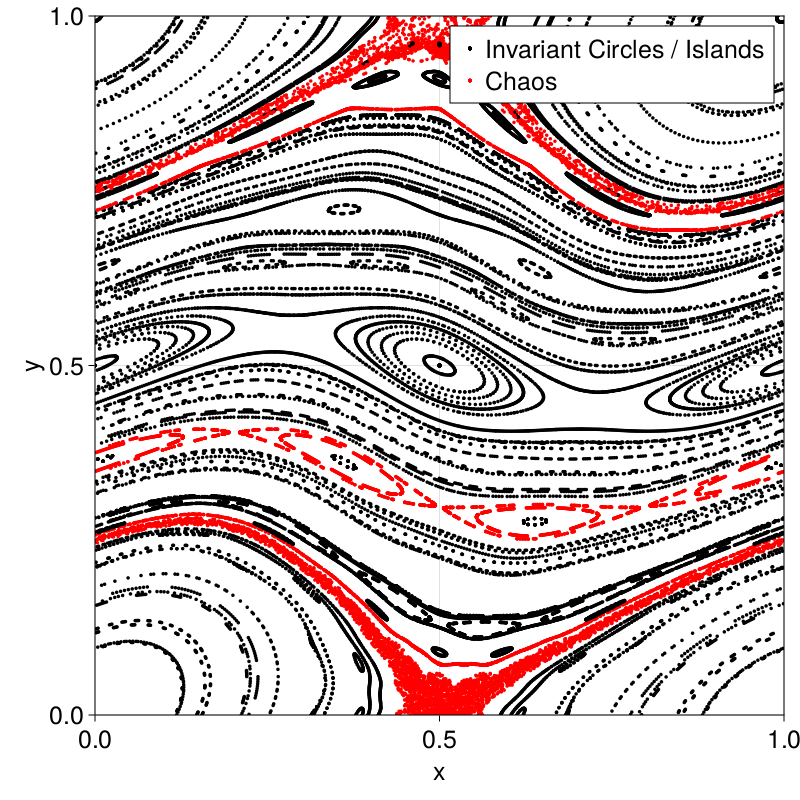

In [5]:
markersize=5
f = Figure(;resolution, fontsize);
ax = Axis(f[1,1], xlabel="x", ylabel="y");
xlims!(0, 1); ylims!(0,1)
for ii = (1:Ncircle)
    if rnorms[ii] < rtol
        CairoMakie.scatter!(xs[ii][1,:], xs[ii][2,:]; color=:black, markersize, label="Invariant Circles / Islands")
    else
        CairoMakie.scatter!(xs[ii][1,:], xs[ii][2,:]; color=:red, markersize, label="Chaos")
    end
end
axislegend(ax, merge=true)
f

The above is a plot which shows the trajectories as black if the extrapolation algorithm converged to the tolerance of `1e-7` and red if they did not. We see that the red trajectories did not converge quickly, and they correlate strongly with whether the trajectory is in chaos. We can check the filter length for the values of $K$ we iterated over:

In [6]:
for Ki = Kinit:Kstride:Kmax
    Ksum = sum(Ks .== Ki)
    println("Number of trajectories for K=$(Ki) is $(Ksum)")
end

Number of trajectories for K=50 is 56
Number of trajectories for K=100 is 20
Number of trajectories for K=150 is 4
Number of trajectories for K=200 is 2
Number of trajectories for K=250 is 4
Number of trajectories for K=300 is 1
Number of trajectories for K=350 is 1
Number of trajectories for K=400 is 12


We see that most trajectories are classified when $K \leq 200$, with only a few being classified later. Additionally, those that are mis-classified tend to be at the edges of island chains or chaos.

Now, we turn to finding models for the invariant circles. We do this via the function `get_circle_info`.

In [7]:
zs = Vector{FourierCircle}(undef, Ncircle)
for ii = (1:Ncircle)[rnorms .< rtol]
    zs[ii] = get_circle_info(hs[ii], cs[ii])
end

Additionally, for the special case where we need to work with observations from $h : \mathbb{T}\times\mathbb{R} \to \mathbb{R}^2$, we have a plotting routine that can be used to plot the invariant circles in $\mathbb{R}^2$ given an inverse function $h^{-1}$. This is done in the following:

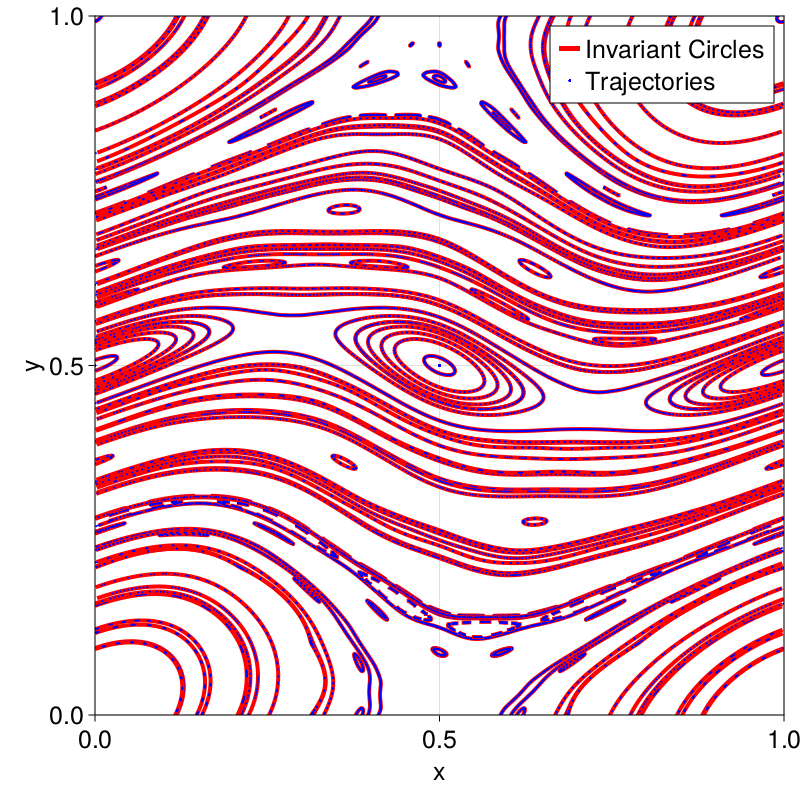

In [8]:
f = Figure(;resolution, fontsize);
ax = Axis(f[1,1], xlabel="x", ylabel="y")
xlims!(0, 1); ylims!(0,1)
for ii = (1:Ncircle)[rnorms .< rtol]
    lines_periodic!(ax, zs[ii], hinv; N=500, color=:red, linewidth=4, label="Invariant Circles")
    scatter!(xs[ii][1,:], xs[ii][2,:], markersize=3, color=:blue, label="Trajectories")
end
axislegend(ax, merge=true)
f

In the above plot, we have plotted the trajectories on the found invariant circles. We see that the trajectories qualitatively match well. Additionally, we can use the function `get_circle_residual` to find a validation error. This is useful in automatically identifying cases where the found Fourier series is incorrect.

In [9]:
N_norm = 6;
errs_validation = zeros(Ncircle)
for ii = (1:Ncircle)[rnorms .< rtol]
    res = get_circle_residual((x) -> h(F(hinv(x))), zs[ii], N_norm)
    errs_validation[ii] = norm(res)/sqrt(length(res))
end
ind = rnorms .< rtol

println("Invariant circle validation errors:
   smallest --- $(minimum(errs_validation[ind]))
   largest  --- $(maximum(errs_validation[ind]))
   median   --- $(sort!(errs_validation[ind])[sum(ind)÷2])
")

Invariant circle validation errors:
   smallest --- 2.0211746724319608e-15
   largest  --- 3.0221917070596794e-5
   median   --- 5.7912433203985446e-9



---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*